# Описание

## Цель

Изучение метода логистической регрессии, метода опорных векторов.  
Изучение методов работы с текстовыми данными.

## Задачи

1. LR, SVM и калибровка вероятностей.
* Сравнение моделей с помощью ROC, PR кривых.
* Визуализация в подходах SVM, LR.
* Калибровка вероятностей.
2. Работа с текстами.
* Разведочный анализ и предобработка данных.
* Токенизация.
* Кастомный токенайзер.
* Обучение модели.
* tf-idf векторайзер.


## Входные данные

1. Синтетические данные.
2. Датасет из Твиттера. Описание данных можно найти [здесь](https://www.kaggle.com/competitions/nlp-getting-started/data)

### LR, SVM и калибровка вероятностей

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)

In [ ]:
np.random.seed(42)

#### Сравнение моделей с помощью ROC, PR



Сгенерируем синтетические данные.

In [ ]:
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

In [ ]:
# фиксируем random_state для воспроизводимости результатов
X, y = make_classification(
    n_samples=10000, n_features=10, n_informative=5, n_redundant=5, random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Заметим, что данные сгенерированы так, что 5 последних столбцов линейно зависимы с предыдущими

__Случайный классификатор__

Для начала зададим самую простую модель, которая на каждом объекте выдаёт случайный ответ. По тестовой выборке вычислим AUC-ROC, AUC-PR.

In [ ]:
from sklearn.dummy import DummyClassifier
random_classifier = DummyClassifier(strategy='uniform', random_state=42).fit(X_train, y_train)
y_random = random_classifier.predict_proba(X_test)[:,1]
y_random

array([0.5, 0.5, 0.5, ..., 0.5, 0.5, 0.5])

Напишем пайплайн для отрисовки ROC и PR кривых, сохранения метрик.

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import average_precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay

Random Classifier metrics
AUC-PR: 0.75283
AUC-ROC: 0.50000


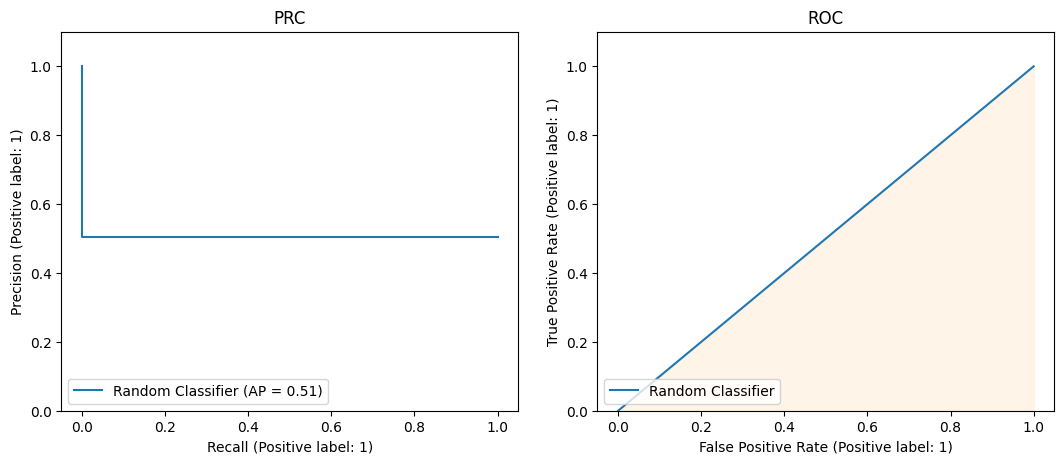

In [ ]:
def depict_pr_roc(y_true, y_pred, classifier_name='Some Classifier', ax=None):
  if ax is None:
    fig, ax = plt.subplots(1, 2, figsize=(11, 5))

  print(classifier_name, 'metrics')
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  ax[0].step(recall, precision, where = 'post', label = classifier_name + f' (AP = {average_precision_score(y_true, y_pred):.2f})')
  ax[0].set_xlabel('Recall (Positive label: 1)')
  ax[0].set_ylabel('Precision (Positive label: 1)')
  ax[0].set_title("PRC")
  ax[0].set_ylim(0, 1.1)
  ax[0].legend(loc = 'lower left')
  print('AUC-PR: %.5f' % auc(recall, precision))

  fpr, tpr, _ = roc_curve(y_true, y_pred)
  ax[1].plot(fpr, tpr, label = classifier_name)
  ax[1].fill_between(fpr, tpr, 0, color = 'bisque', alpha = 0.4)
  ax[1].set_xlabel('False Positive Rate (Positive label: 1)')
  ax[1].set_ylabel('True Positive Rate (Positive label: 1)')
  ax[1].set_title("ROC")
  ax[1].set_ylim(0, 1.1)
  ax[1].legend(loc = 'lower left')
  print('AUC-ROC: %.5f' % roc_auc_score(y_true, y_pred))

  plt.tight_layout(pad = 2)
  plt.show()

depict_pr_roc(y_test, y_random, 'Random Classifier');

In [ ]:
# dataframe для сравнения
# методов классификации по метрикам
df_metrics = pd.DataFrame(columns=['AUC_PR', 'AUC_ROC', 'reg_const'])
precision, recall, _ = precision_recall_curve(y_test, y_random)
  # добавление очередной строки с характеристиками метода
df_metrics.loc['Random Classifier'] = [
      auc(recall, precision),
      roc_auc_score(y_test, y_random),
      0
]

  # по аналогии результаты следующих экспериментов можно будет собрать в табличку
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.5,0.0


In [ ]:
def data_add(classifier_name, y_true, y_pred, coef):
  auc_pr = auc(precision_recall_curve(y_true, y_pred)[1], precision_recall_curve(y_true, y_pred)[0])
  auc_roc = roc_auc_score(y_test, y_svc)
  df_metrics.loc[classifier_name] = [
      auc_pr,
      auc_roc,
      coef
  ]

__Support Vector Machine (Linear Kernel)__

Обучим метод опорных векторов

Подберем параметр регуляризации `C` с точки зрения AUC-PR, воспользовавшись GridSearch


In [ ]:
def AUCPR(y_true, y_pred):
  precision, recall, _ = precision_recall_curve(y_true, y_pred)
  return auc(recall, precision)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

In [ ]:
scorer = make_scorer(AUCPR)

In [ ]:
param_grid = {
    'C': [0.01, 0.1, 1, 10]
}
svc = SVC(kernel = 'linear')
grid_search_svc = GridSearchCV(svc, param_grid, cv = 5, scoring = scorer, verbose = 10)
grid_search_svc.fit(X_train, y_train)
grid_search_svc.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START C=0.01......................................................
[CV 1/5; 1/4] END .......................C=0.01;, score=0.837 total time=   2.1s
[CV 2/5; 1/4] START C=0.01......................................................
[CV 2/5; 1/4] END .......................C=0.01;, score=0.825 total time=   3.4s
[CV 3/5; 1/4] START C=0.01......................................................
[CV 3/5; 1/4] END .......................C=0.01;, score=0.840 total time=   2.5s
[CV 4/5; 1/4] START C=0.01......................................................
[CV 4/5; 1/4] END .......................C=0.01;, score=0.836 total time=   2.9s
[CV 5/5; 1/4] START C=0.01......................................................
[CV 5/5; 1/4] END .......................C=0.01;, score=0.835 total time=   2.7s
[CV 1/5; 2/4] START C=0.1.......................................................
[CV 1/5; 2/4] END ........................C=0.1;,

{'C': 1}

Лучший гиперпараметр: `С = 1`

  На тестовой части:
  - построим ROC и PR кривые,
  - посчитаем AUC-ROC, AUC-PR с точностью до 5 знаков

SVC metrics
AUC-PR: 0.83369
AUC-ROC: 0.77514


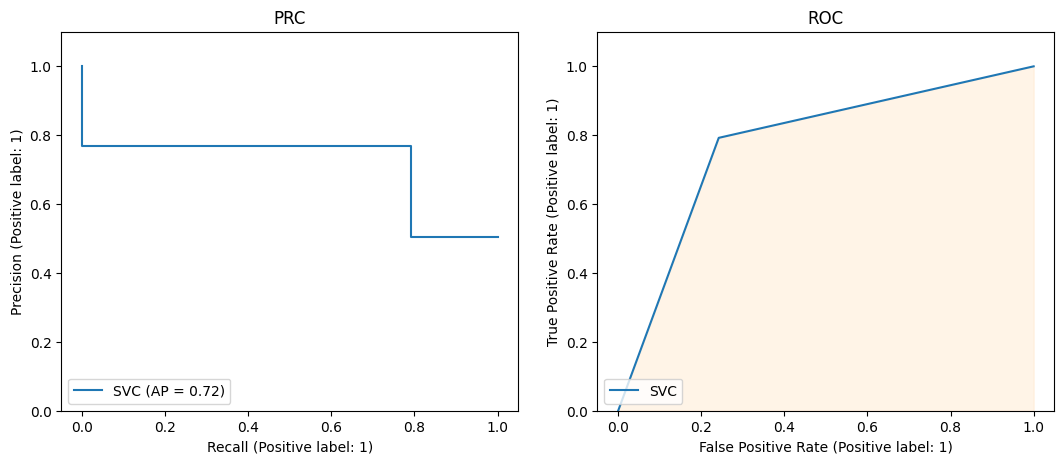

In [ ]:
y_svc = grid_search_svc.predict(X_test)
depict_pr_roc(y_test, y_svc, 'SVC')

Сравним AUC-ROC и AUC-PR для SVC модели с этими же метриками для случайного классификатора.

In [ ]:
data_add('SVC', y_test, y_svc, 1)
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.0
SVC,0.833686,0.775138,1.0


__Logistic Regression__


Проделаем то же самое для логистической регрессии с L2 регуляризацией:


*   подберем гиперпараметр C, используя метрику AUC-PR
*   нарисуем ROC, PR кривые для тестовой части
*   выведем метрики для тестовых данных и сравним их с предыдущими результатами



In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
log_reg = LogisticRegression(penalty = 'l2')
param_grid = {
    'C': [0.01, 0.1, 1, 10]
}
grid_reg = GridSearchCV(log_reg, param_grid, cv = 5, scoring = scorer, verbose = 10)
grid_reg.fit(X_train, y_train)
grid_reg.best_params_

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5; 1/4] START C=0.01......................................................
[CV 1/5; 1/4] END .......................C=0.01;, score=0.836 total time=   0.1s
[CV 2/5; 1/4] START C=0.01......................................................
[CV 2/5; 1/4] END .......................C=0.01;, score=0.826 total time=   0.1s
[CV 3/5; 1/4] START C=0.01......................................................
[CV 3/5; 1/4] END .......................C=0.01;, score=0.842 total time=   0.1s
[CV 4/5; 1/4] START C=0.01......................................................
[CV 4/5; 1/4] END .......................C=0.01;, score=0.834 total time=   0.1s
[CV 5/5; 1/4] START C=0.01......................................................
[CV 5/5; 1/4] END .......................C=0.01;, score=0.832 total time=   0.0s
[CV 1/5; 2/4] START C=0.1.......................................................
[CV 1/5; 2/4] END ........................C=0.1;,

{'C': 0.01}

In [ ]:
y_reg = grid_reg.predict(X_test)
data_add('LogReg', y_test, y_reg, 0.01)
df_metrics

,AUC_PR,AUC_ROC,reg_const
Random Classifier,0.752833,0.500000,0.00
SVC,0.833686,0.775138,1.00
LogReg,0.831672,0.775138,0.01


Нарисуем ROC, PR кривые для тестовой части для всех 3 классификаторов на одном графике

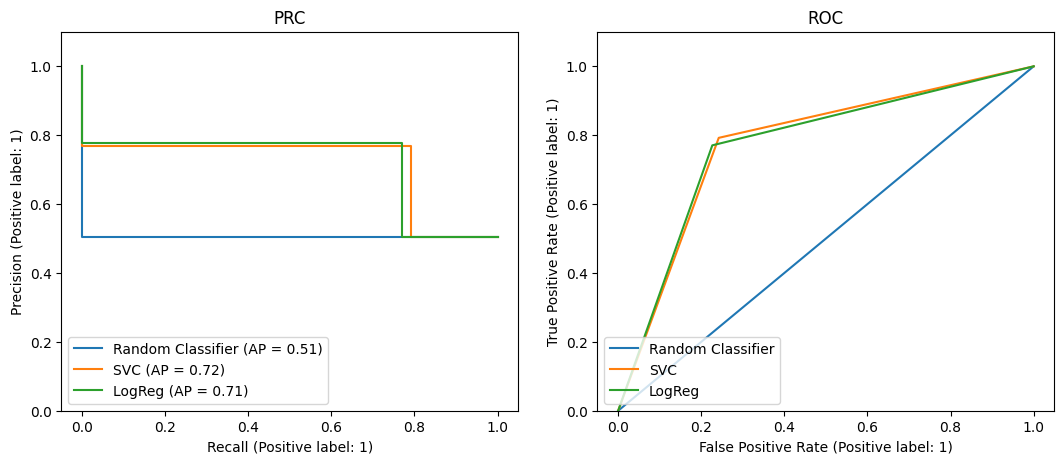

In [ ]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (11,5))
precision = [precision_recall_curve(y_test, y)[0] for y in [y_random, y_svc, y_reg]]
recall = [precision_recall_curve(y_test, y)[1] for y in [y_random, y_svc, y_reg]]
fpr = [roc_curve(y_test, y)[0] for y in [y_random, y_svc, y_reg]]
tpr = [roc_curve(y_test, y)[1] for y in [y_random, y_svc, y_reg]]

for R, P, FPR, TPR, y, classifier_name in zip(recall, precision, fpr, tpr, [y_random, y_svc, y_reg], ['Random Classifier', 'SVC', 'LogReg']):
  ax[0].step(R, P, where = 'post', label = classifier_name + f' (AP = {average_precision_score(y_test, y):.2f})')
  ax[1].plot(FPR, TPR, label = classifier_name)

ax[0].set_xlabel('Recall (Positive label: 1)')
ax[0].set_ylabel('Precision (Positive label: 1)')
ax[0].set_title("PRC")
ax[0].set_ylim(0, 1.1)
ax[0].legend(loc = 'lower left')

ax[1].set_xlabel('False Positive Rate (Positive label: 1)')
ax[1].set_ylabel('True Positive Rate (Positive label: 1)')
ax[1].set_title("ROC")
ax[1].set_ylim(0, 1.1)
ax[1].legend(loc = 'lower left')

plt.tight_layout(pad = 2)
plt.show()

__Вывод__:  
LR и SVM практически не отличаются

#### Визуализация в подходах SVM, LR



В названии метода опорных векторов присутствуют некоторые "опорные векторы". Это объекты из обучающей выборки, которые задают положение разделяющей гиперплоскости.

* Сгенерируем синтетические данные с помощью `make_classification` __с 2 признаками__, обучим на них метод опорных векторов.

* Визуализируем разделяющую прямую и выделим опорные векторы.

In [ ]:
from sklearn.inspection import DecisionBoundaryDisplay

In [ ]:
X_train, y_train = make_classification(n_samples = 350, n_features = 2, n_informative = 2, n_redundant = 0, random_state = 42)
model_svc = SVC(kernel = 'linear')
model_svc.fit(X_train, y_train);

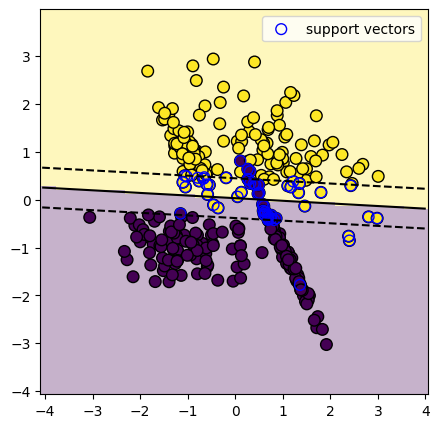

In [ ]:
def plot_svm_2D(X, y, model):
  _, ax = plt.subplots(figsize=(5, 5))

  common_params = {"estimator": model, "X": X, "ax": ax}
  DecisionBoundaryDisplay.from_estimator(
      **common_params,
      response_method="predict",
      plot_method="pcolormesh",
      alpha=0.3,
  )
  DecisionBoundaryDisplay.from_estimator(
      **common_params,
      response_method="decision_function",
      plot_method="contour",
      levels=[-1, 0, 1],
      colors=["k", "k", "k"],
      linestyles=["--", "-", "--"],
  )

  ax.scatter(X[:, 0], X[:, 1], c = y, s = 70, edgecolors = 'k')

  vec = model.support_vectors_
  # Label the data points (optional)
  ax.scatter( vec[:, 0],
              vec[:, 1],
              label='support vectors',
              s= 60,
              linewidth=1,
              edgecolor="blue",
              facecolors='none')
  ax.legend(loc="upper right")
  plt.show()

plot_svm_2D(X_train, y_train, model_svc)

В отличие от метода опорных векторов, логистическая регрессия не пытается построить разделяющую гиперплоскость с максимальным отступом, а приближает в каждой точке пространства объектов вероятность положительных ответов $p(y=+1|x)$.  
Нарисуем это распределение на плоскости.

In [ ]:
model_reg = LogisticRegression()
model_reg.fit(X_train, y_train);

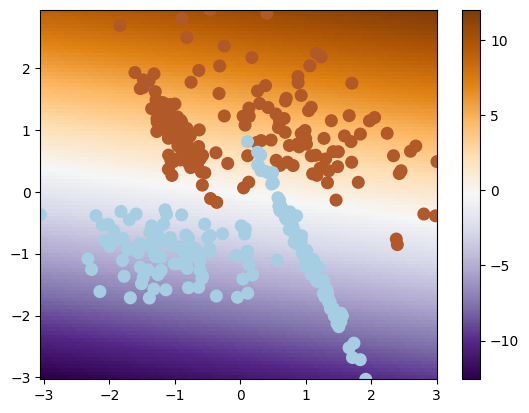

In [ ]:
def plot_logreg_2D(X, y, model):

    #создали сетку
    xx = np.linspace(X[:,0].min(), X[:,0].max(), 100)
    yy = np.linspace(X[:,1].min(), X[:,1].max(), 100)
    YY, XX = np.meshgrid(yy, xx)
    xy = np.vstack([XX.ravel(), YY.ravel()]).T

    #Ответы модели для сетки для отрисовки распределения
    Z = model.decision_function(xy)
    Z = Z.reshape((xx.shape[0], -1)).T


    image = plt.imshow(Z, interpolation='nearest',
                       extent=(xx.min(), xx.max(), yy.min(), yy.max()),
                       aspect='auto', origin='lower', cmap=plt.cm.PuOr_r)

    #Отрисовали выборку
    plt.scatter(X[:, 0], X[:, 1], c = y, s = 70,
                cmap=plt.cm.Paired)

    plt.colorbar(image)


plot_logreg_2D(X_train, y_train, model_reg)

Область, в которой модель не уверена, обозначена с помощью белой полосы.

#### Калибровка вероятностей



Перейдём к оценке качества выдаваемых алгоритмами вероятностей. Начнём с калибровочных кривых.

Допустим, алгоритм возвращает некоторые числа от нуля до единицы. Хотим понять, хорошо ли он оценивает вероятность.

Хорошо откалиброванный  классификатор должен выдавать значения так, чтобы среди образцов, для которых он дал значение, близкое к $\alpha$, примерно $\alpha * 100 \%$ фактически принадлежали к положительному классу. (Например, если классификатор выдает 0.3 для некоторых, то 30% из них должны принадлежать классу 1)

Для построения калибровочной кривой воспользуемся следующим алгоритмом:

Разобьем отрезок $[0, 1]$ на несколько маленьких отрезков одинаковой длины.

Рассмотрим $i$-й отрезок с границами $[a_i, b_i]$ и предсказания $p_1, p_2, \dots, p_k$, которые попали в него. Пусть им соответствуют истинные ответы $y_1, y_2, \dots, y_k$. Если алгоритм выдает корректные вероятности, то среди этих истинных ответов должно быть примерно $(a_i + b_i) / 2$ единиц. Иными словами, если нарисовать кривую, у которой по оси X отложены центры отрезков, а по оси Y — доли единичных ответов этих в отрезках, то она должна оказаться диагональной.

In [ ]:
def plot_calibration_curve(y_test, preds, classifier_name):
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10

    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)] == 1) / len(y_test[(preds >= l) & (preds < r)]))

    plt.figure(figsize=(6,6))
    plt.plot([0, 1], [0, 1], linestyle = '--', color = 'k', label = 'Perfectly Calibrated')
    plt.plot(bin_middle_points, bin_real_ratios, linestyle = '-.', color = 'blue', label = classifier_name)
    plt.legend()
    plt.title("Calibration Curve")
    plt.ylim([-0.05, 1.05])
    plt.grid()
    plt.show()

Сгенерируем синтетические данные, построим калибровочные кривые на тестовой части для логистической регрессии и метода опорных векторов.

Отрисуем калибровочную кривую идеально откалиброванной модели (диагональ)

Для получения вероятностей из метода опорных векторов воспользуемся формулой:

$$probas = \frac{preds - min(preds)}{max(preds) - min(preds)}$$

где $preds$ - результат работы метода decision_function

In [ ]:
X_test, y_test = make_classification(n_samples = 10000, n_features = 2, n_informative = 2, n_redundant = 0, random_state = 42)

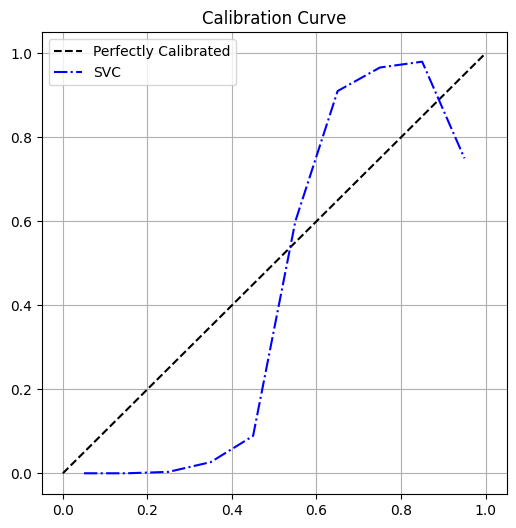

In [ ]:
preds_svc = model_svc.decision_function(X_test)
probas_svc = (preds_svc - min(preds_svc)) / (max(preds_svc) - min(preds_svc))
plot_calibration_curve(y_test, probas_svc, "SVC")

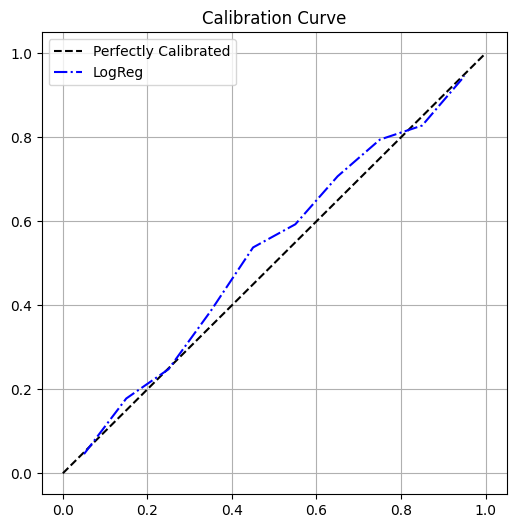

In [ ]:
probas_reg = model_reg.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probas_reg, "LogReg")

__Вывод__:

Логистическая регрессия откалибрована сильно лучше, чем SVМ. Логистическая регрессия близка к идеальному классификатору

Изучим распределение ответов классификаторов.

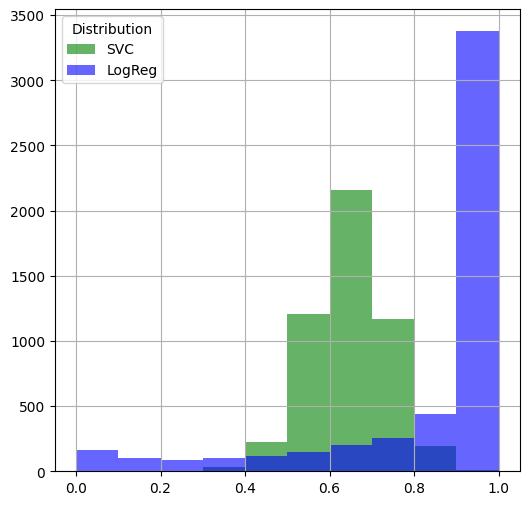

In [ ]:
bin_middle_points = []
bin_real_ratios_svc, bin_real_ratios_reg = [], []
n_bins = 10

for i in range(n_bins):
    l = 1.0 / n_bins * i
    r = 1.0 / n_bins * (i + 1)
    bin_middle_points.append(round((l + r) / 2, 2))
    bin_real_ratios_svc.append(np.sum(y_test[(probas_svc >= l) & (probas_svc < r)] == 1))
    bin_real_ratios_reg.append(np.sum(y_test[(probas_reg >= l) & (probas_reg < r)] == 1))

plt.figure(figsize=(6,6))
plt.bar(bin_middle_points, bin_real_ratios_svc, width = 0.1, color = 'green', alpha = 0.6, label = 'SVC')
plt.bar(bin_middle_points, bin_real_ratios_reg, width = 0.1, color = 'blue', alpha = 0.6, label = 'LogReg')
plt.legend(title = 'Distribution')
plt.grid()
plt.show()

Такое распределение связано с тем, что логистическая регрессия за счет своей лосс функция максимизирует свою уверенность в предсказаниях. С другой стороны, SVC не обязана быть хорошо откалибрована, поскольку она заточена под то, чтобы строить разделяющую поверхность, затем только к выходам модели применяется нормализация, чтобы это было лишь похоже на вероятности

Воспользуемся `CalibratedClassifierCV` из `sklearn` для калибровки вероятностей метода опорных векторов на обучении и построим с его помощью  предсказания для тестовой выборки.

In [ ]:
from sklearn.calibration import CalibratedClassifierCV

In [ ]:
model = SVC(kernel = 'linear')
svc_calibr = CalibratedClassifierCV(model, cv = 5)
svc_calibr.fit(X_train, y_train);

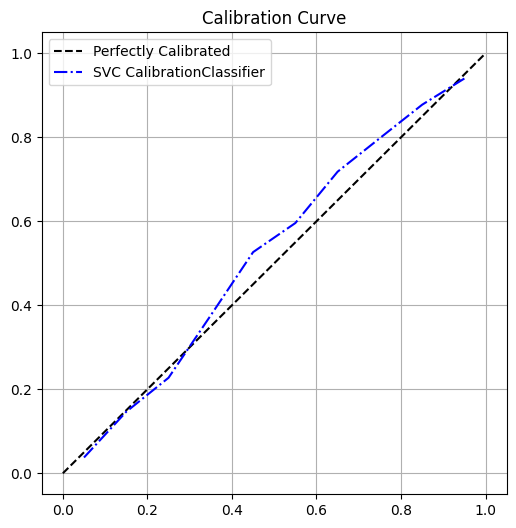

In [ ]:
probas_svc_calibr = svc_calibr.predict_proba(X_test)[:, 1]
plot_calibration_curve(y_test, probas_svc_calibr, "SVC CalibrationClassifier")

Видим значительное улучшение калибровочной кривой.

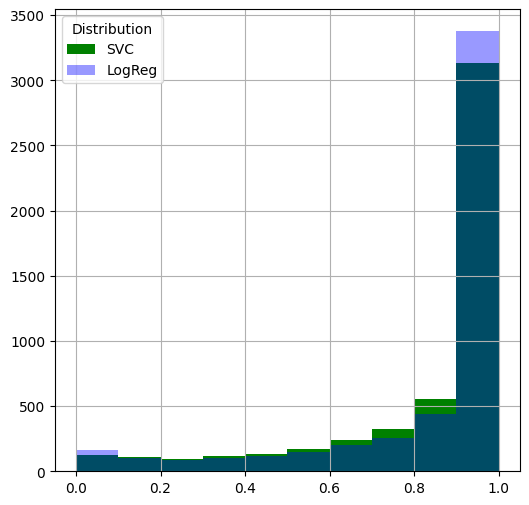

In [ ]:
bin_middle_points = []
bin_real_ratios_svc, bin_real_ratios_reg = [], []
n_bins = 10

for i in range(n_bins):
    l = 1.0 / n_bins * i
    r = 1.0 / n_bins * (i + 1)
    bin_middle_points.append(round((l + r) / 2, 2))
    bin_real_ratios_svc.append(np.sum(y_test[(probas_svc_calibr >= l) & (probas_svc_calibr < r)] == 1))
    bin_real_ratios_reg.append(np.sum(y_test[(probas_reg >= l) & (probas_reg < r)] == 1))

plt.figure(figsize=(6,6))
plt.bar(bin_middle_points, bin_real_ratios_svc, width = 0.1, color = 'green', alpha = 1, label = 'SVC')
plt.bar(bin_middle_points, bin_real_ratios_reg, width = 0.1, color = 'blue', alpha = 0.4, label = 'LogReg')
plt.legend(title = 'Distribution')
plt.grid()
plt.show()

Реализуем собственную функцию калибровки вероятностей.

Воспользуемся калибровкой `Platt` для SVC.

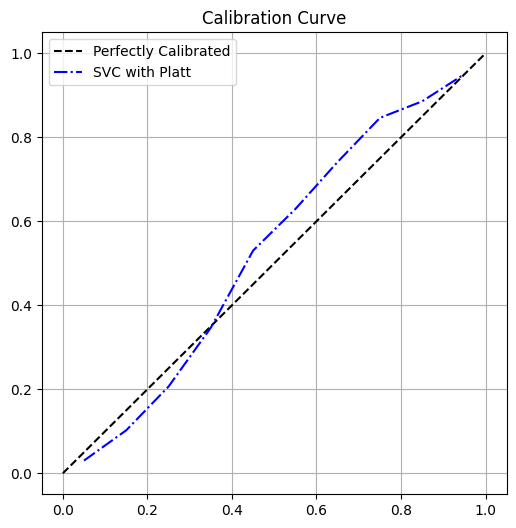

In [ ]:
Platt = 1 / (1 + np.exp(-(model_svc.coef_ @ X_test.T + model_svc.intercept_[:,None])))
plot_calibration_curve(y_test, Platt.squeeze(), "SVC with Platt")

Заметим, что мы получили практически то же самое, что и `CalibratedClassifierCV`, что неудивительно, поскольку по дефолту в `CalibratedClassifierCV` используется `sigmoid method` для калибровки, а это и есть `Platt`.  
Небольшое отличие все же есть, это связано с тем, что в `CalibratedClassifierCV` используется кросс-валидация

## Работа с текстами

Будем строить классификатор текстов.

Мы будем работать с датасетом постов из твиттера. Нам предстоит решать задачу бинарной классификации - определять содержатся ли в твитте информация о настоящей катастрофе/инциденте или нет.

In [ ]:
import numpy as np
import pandas as pd
from typing import  List
import matplotlib.pyplot as plt
import seaborn as sns
from string import punctuation

In [ ]:
data = pd.read_csv('train.csv').drop(['id'], axis = 1)
data.head()

,keyword,location,text,target
0,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


#### Разведочный анализ и предобработка данных

Выведем информацию о пропусках в данных. Если пропуски присутствуют, заполним их пустой строкой.

In [ ]:
data.isnull().sum()

keyword       61
location    2533
text           0
target         0
dtype: int64

Пропуски есть, заполним их

In [ ]:
data.fillna('', inplace = True)
data.head()

,keyword,location,text,target
0,,,Our Deeds are the Reason of this #earthquake M...,1
1,,,Forest fire near La Ronge Sask. Canada,1
2,,,All residents asked to 'shelter in place' are ...,1
3,,,"13,000 people receive #wildfires evacuation or...",1
4,,,Just got sent this photo from Ruby #Alaska as ...,1


Немного посмотрим на наши данные.


Посмотрим на колонку "keyword" - возьмем 10 наиболее встречающихся значений, построим диаграмму распределения классов в зависимости от значения keyword, сделаем выводы.

In [ ]:
popular_keywords = list(data['keyword'].value_counts().index)[1:11]
popular_keywords

['fatalities',
 'deluge',
 'armageddon',
 'sinking',
 'damage',
 'harm',
 'body%20bags',
 'evacuate',
 'fear',
 'outbreak']

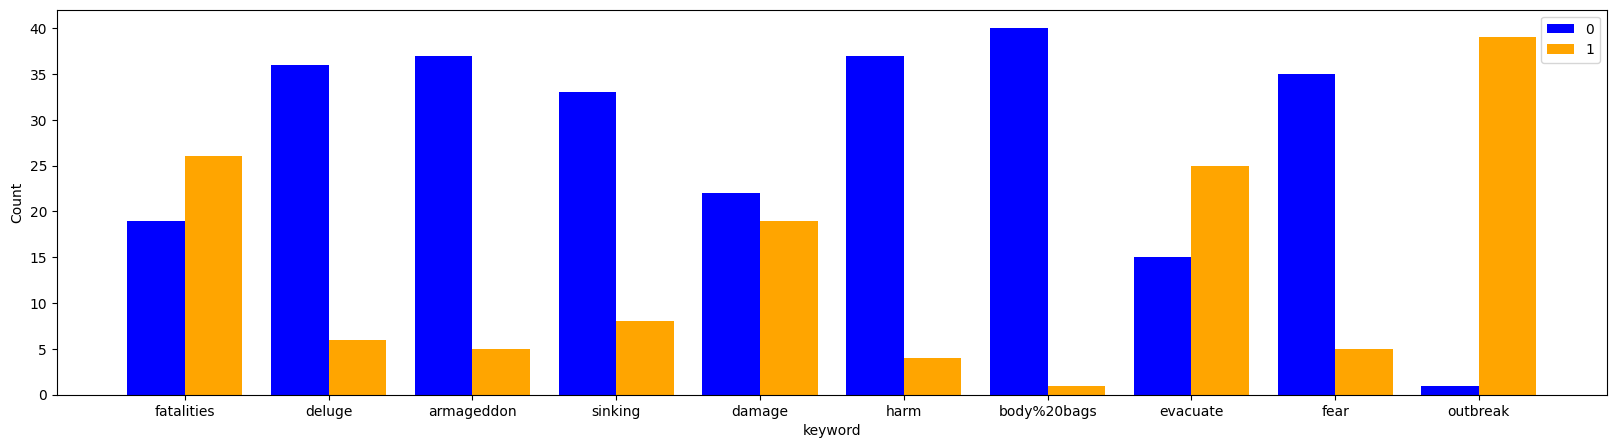

In [ ]:
count0 = [data[(data['keyword'] == popular_keywords[i]) & (data['target'] == 0)].shape[0] for i in range(10)]
count1 = [data[(data['keyword'] == popular_keywords[i]) & (data['target'] == 1)].shape[0] for i in range(10)]
fig, ax = plt.subplots(figsize = (20, 5))
X_axis = np.arange(len(popular_keywords))

ax.bar(X_axis-0.2, count0, width = 0.4, label = '0', color = 'blue')
ax.bar(X_axis+0.2, count1, width = 0.4, label = '1', color = 'orange')
ax.set_xticks(X_axis, popular_keywords)
ax.set_xlabel('keyword')
ax.set_ylabel('Count')
plt.legend()

plt.show()

Можем видеть сильно неравномерное распределение

Уберем столбец с индексом и объединим все три текстовых столбца в один.

In [ ]:
import string
import re

In [ ]:
data['Word'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']
X, y = data['Word'], data['target']
data.head()

,keyword,location,text,target,Word
0,,,Our Deeds are the Reason of this #earthquake M...,1,Our Deeds are the Reason of this #earthquake...
1,,,Forest fire near La Ronge Sask. Canada,1,Forest fire near La Ronge Sask. Canada
2,,,All residents asked to 'shelter in place' are ...,1,All residents asked to 'shelter in place' ar...
3,,,"13,000 people receive #wildfires evacuation or...",1,"13,000 people receive #wildfires evacuation ..."
4,,,Just got sent this photo from Ruby #Alaska as ...,1,Just got sent this photo from Ruby #Alaska a...


In [ ]:
y.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

Распределение классов не совсем равномерное

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
X_train

1186    bridge%20collapse  Ashes 2015: AustraliaÛªs c...
4071    hail Carol Stream, Illinois GREAT MICHIGAN TEC...
5461    police Houston  CNN: Tennessee movie theater s...
5787    rioting  Still rioting in a couple of hours le...
7445    wounds Lake Highlands Crack in the path where ...
                              ...                        
5226    obliteration Merica! @Eganator2000 There aren'...
5390    panic  just had a panic attack bc I don't have...
860     blood  Omron HEM-712C Automatic Blood Pressure...
7603      Officials say a quarantine is in place at an...
7270    whirlwind Stamford & Cork (& Shropshire) I mov...
Name: Word, Length: 5329, dtype: object

Далее мы будем пока работать только с train частью. Предобработаем данные (train часть) с помощью CountVectorizer.

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer(encoding = 'utf8')
vectorizer.fit(X_train);

In [ ]:
vectorized_data = vectorizer.transform(X_train)
vectorized_data.shape

(5329, 18455)

5329 текстов, что соответствует размеру X_train,  
18455 различных слов в них

**Работа со словарем**


Получается достаточно большая матрица.  
При этом в тексте есть множество специальных символов, ссылок, прочего мусора.

Посмотрим на словарь, который получился в результате построения CountVectorizer. Напишем функцию, которая печатает ответы на следующие вопросы:

1. Найдем количество слов, содержащих цифры.

2. Найдем количество слов, которые содержат символы пунктуации.

3. Найдем количество хэштегов (токенов, начинающихся с #) и упоминаний (токенов, начинающихся с @).

In [ ]:
def contains_digit(s: str) -> bool:
    #Проверка, содержит ли слово цифры
    return any(char.isdigit() for char in s)

def contains_punctuation(s: str) -> bool:
    #Проверка, содержит ли слово пунктуацию
    punctuations = string.punctuation
    return any(char in punctuations for char in s)

def is_hashtag(s: str) -> bool:
    #Проверка, является ли слово хэштегом
    return s[0] == '#' if len(s) > 0 else 0

def is_mention(s: str) -> bool:
    #Проверка, является ли слово упоминанием
    return s[0] == '@' if len(s) > 0 else 0

def investigate_vocabulary(vocabulary):
    keys = list(vocabulary.keys())
    info = {
        'digit': 0,
        'punctuation': 0,
        'hashtags': 0,
        'mentions': 0
    }

    for key in keys:
      info['digit']       += contains_digit(key)
      info['punctuation'] += contains_punctuation(key)
      info['hashtags']    += is_hashtag(key)
      info['mentions']    += is_mention(key)

    print('With digit:      ', info['digit']
          )
    print('With punctuation:', info['punctuation']
          )
    print('Hashtags:        ', info['hashtags']
          )
    print('Mentions:        ', info['mentions']
          )

In [ ]:
dummy_vocab = {'th1nk' : 0,
               'think333' : 1,
               'think.' : 2,
               'th!nk' : 3,
               'th...nk' : 4,
               '#think' : 5,
               '@think' : 6,
               '@thinking':7,
               '@nothink' : 8,
               'think' : 9}
investigate_vocabulary(dummy_vocab)

With digit:       2
With punctuation: 7
Hashtags:         1
Mentions:         3


In [ ]:
investigate_vocabulary(vectorizer.vocabulary_
                       )

With digit:       3812
With punctuation: 315
Hashtags:         0
Mentions:         0


Получаем 0 в *Hashtags* и *Mentions*.  
Это связано с тем, что по умолчанию `tokenizer` в `CountVectorizer` удаляет символы пунктуации

#### Токенизация

По умолчанию CountVectorizer определяет токен (слово) как последовательность 2 и более цифр или букв. Пунктуационные символы воспринимаются как разделитель токенов. Такой подход может быть не очень полезен при анализе твитов.

Существуют токенайзеры - модели, которые разбивают тексты на токены (слова), они разные в зависимости от задачи. Например, в nltk есть токенизатор для твитов - TweetTokenizer.

Попробуем применить CountVectorizer с этим токенизатором. Применим TweetTokenizer и сравним ответы с предыдущим пунктом.

In [ ]:
import nltk

In [ ]:
from nltk.tokenize import TweetTokenizer
# Чтобы узнать, какие параметры есть у этого токенайзера - используем help(TweetTokenizer)

help(TweetTokenizer)

Help on class TweetTokenizer in module nltk.tokenize.casual:

class TweetTokenizer(nltk.tokenize.api.TokenizerI)
 |  TweetTokenizer(preserve_case=True, reduce_len=False, strip_handles=False, match_phone_numbers=True)
 |  
 |  Tokenizer for tweets.
 |  
 |      >>> from nltk.tokenize import TweetTokenizer
 |      >>> tknzr = TweetTokenizer()
 |      >>> s0 = "This is a cooool #dummysmiley: :-) :-P <3 and some arrows < > -> <--"
 |      >>> tknzr.tokenize(s0) # doctest: +NORMALIZE_WHITESPACE
 |      ['This', 'is', 'a', 'cooool', '#dummysmiley', ':', ':-)', ':-P', '<3', 'and', 'some', 'arrows', '<', '>', '->',
 |       '<--']
 |  
 |  Examples using `strip_handles` and `reduce_len parameters`:
 |  
 |      >>> tknzr = TweetTokenizer(strip_handles=True, reduce_len=True)
 |      >>> s1 = '@remy: This is waaaaayyyy too much for you!!!!!!'
 |      >>> tknzr.tokenize(s1)
 |      [':', 'This', 'is', 'waaayyy', 'too', 'much', 'for', 'you', '!', '!', '!']
 |  
 |  Method resolution order:
 |     

Тексты выглядят адекватными, поэтому reduce_len применять смысла нет.  
Обязательно нужно поставить strip_handles = False, чтобы слова, начинающиеся с пунктуации не пропускались

In [ ]:
def tweet_tokenizer(text):
  t = TweetTokenizer()
  return t.tokenize(text)

In [ ]:
vectorizer_tweet = CountVectorizer(encoding = 'utf8', tokenizer = tweet_tokenizer)

In [ ]:
tweeted_data = vectorizer_tweet.fit_transform(X_train)
tweeted_data.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 19670)

In [ ]:
investigate_vocabulary(vectorizer_tweet.vocabulary_)

With digit:       3939
With punctuation: 7338
Hashtags:         1470
Mentions:         1679


**Вывод:**   
Отличия в том, что *TweetTokenizer* не пропускает слова, начинающиеся с @ #, что может быть удобно при анализе подобных текстов

#### Кастомный токенайзер


В scikit-learn мы можем оценивать процесс подсчета матрицы через CountVectorizer. У CountVectorizer, как и у других наследников \_VectorizerMixin, есть аргумент tokenizer и preprocessor. preprocessor применяется в самом начале к каждой строке вашего датасета, tokenizer же принимает строку и возвращает токены.
Напишем кастомный токенайзер, который будет делать следующее:

0. Приведет все буквы к нижнему регистру
1. Разобьет текст на токены с помощью TweetTokenizer из пакета nltk
2. Удалит все токены содержащие не латинские буквы, кроме смайликов (будем считать ими токены содержащие только пунктуацию и, как минимум, одну скобочку) и хэштегов, которые после начальной # содержат только латинские буквы.
3. Удалит все токены, которые перечислены в nltk.corpus.stopwords.words('english')
4. Проведет стемминг с помощью SnowballStemmer


In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from nltk.stem.snowball import EnglishStemmer

In [ ]:
def contains_only_latin_letters(s: str) -> bool:
    #Проверка, содержит ли слово только латинские буквы
    return bool(re.compile("^[a-zA-Z]+$").match(s))

def is_emoji(s: str) -> bool:
    #Проверка, является ли слово смайликом
    return all(char in string.punctuation for char in s) and s.count(')') >= 1

def is_hashtag(s: str) -> bool:
    #Проверка, является ли слово хэштегом
    if len(s) > 1 and s[0] == '#' and contains_only_latin_letters(s[1:]):
      return True

def custom_tokenizer(s: str) -> List[str]:
    #Кастомный токенайзер
    stemmer = EnglishStemmer()
    #0
    s = s.lower()

    #1
    tokens = np.array(tweet_tokenizer(s))

    #2, 3
    indexes = [0] * len(tokens)
    for i in range(len(tokens)):
      token = tokens[i]
      if token in nltk.corpus.stopwords.words('english'):
        indexes[i] = False
      elif is_hashtag(token) or is_emoji(token) or contains_only_latin_letters(token):
        indexes[i] = True
      else:
        indexes[i] = False
    tokens = tokens[indexes]
    #4
    for i in range(len(tokens)):
      tokens[i] = stemmer.stem(tokens[i])
    return tokens.tolist()

In [ ]:
custom_tokenizer('She LOVES painting :-) #art')

['love', 'paint', ':-)', '#art']

Продемонстрируем работу функции на первых десяти текстах в обучающей выборке.

In [ ]:
docs = np.array(X_train)
[custom_tokenizer(docs[i]) for i in range(10)]

[['bridg',
  'ash',
  'australia',
  'collaps',
  'trent',
  'bridg',
  'among',
  'worst',
  'histori',
  'england',
  'bundl',
  'australia'],
 ['hail',
  'carol',
  'stream',
  'illinoi',
  'great',
  'michigan',
  'techniqu',
  'camp',
  'thank',
  '#goblu',
  '#wrestleon'],
 ['polic',
  'houston',
  'cnn',
  'tennesse',
  'movi',
  'theater',
  'shoot',
  'suspect',
  'kill',
  'polic'],
 ['riot', 'still', 'riot', 'coupl', 'hour', 'left', 'class'],
 ['wound',
  'lake',
  'highland',
  'crack',
  'path',
  'wipe',
  'morn',
  'beach',
  'run',
  'surfac',
  'wound',
  'left',
  'elbow',
  'right',
  'knee'],
 ['airplan',
  'somewher',
  'expert',
  'franc',
  'begin',
  'examin',
  'airplan',
  'debri',
  'found',
  'reunion',
  'island',
  'french',
  'air',
  'accid',
  'expert',
  '#mlb'],
 ['bloodi',
  'isol',
  'citi',
  'world',
  'perth',
  'came',
  'kill',
  'indian',
  'fun',
  'video',
  'smirk',
  'remorseless',
  'pakistani',
  'killer',
  'show',
  'boast'],
 ['burn',

#### Обучение модели

1. Применим CountVectorizer с реализованным выше токенизатором к обучающим и тестовым выборкам.

2. Обучим LogisticRegression на полученных признаках.

3. Посчитаем метрику f1-score на тестовых данных.

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
my_vectorizer = CountVectorizer(encoding = 'utf8', tokenizer = custom_tokenizer)
train_tokenized = my_vectorizer.fit_transform(X_train)
test_tokenized = my_vectorizer.transform(X_test)

In [ ]:
model = LogisticRegression()
model.fit(train_tokenized, y_train)
y_pred = model.predict(test_tokenized)
f1_score(y_test, y_pred)

0.752953813104189

#### tf-idf векторайзер

Повторим то же самое с tf-idf векторайзером.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [ ]:
vectorizer = TfidfVectorizer(encoding='utf8', tokenizer = custom_tokenizer)
train_tfidf = vectorizer.fit_transform(X_train)
test_tfidf = vectorizer.transform(X_test)
train_tfidf.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10476)

In [ ]:
model = LogisticRegression()
model.fit(train_tfidf, y_train)
y_pred = model.predict(test_tfidf)
f1_score(y_test, y_pred)

0.7433333333333335

**Вывод:** Результат практически не изменился

В векторайзерах есть параметры min_df и max_df - которые отвечают за ограничения минимальной и максимальной частоте встречаемости токена. Например, если min_df = 3, то мы не учитываем токены, которые встретились менее 3 раз в наших текстах.

Мы можем еще сильнее уменьшить размер нашей матрицы, если отбросим значения df близкие к единице. Скорее всего такие слова не несут много информации о категории, так как встречаются достаточно часто. Ограничим максимальный df в параметрах TfIdfVectorizer, поставив верхнюю границу равную 0.9.

In [ ]:
vectorizer = TfidfVectorizer(encoding = 'utf8', tokenizer = custom_tokenizer, max_df = 0.9)
train_tfidf = vectorizer.fit_transform(X_train)
test_tfidf = vectorizer.transform(X_test)
train_tfidf.shape

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


(5329, 10476)

**Вывод:**  
Ничего не изменилось.  
Документы сильно разные, нет слов, встречающихся настолько часто.

Также мы можем уменьшить размер матрицы, удаляя слова со слишком маленьким df.

In [ ]:
vectorizer = TfidfVectorizer(encoding = 'utf8', tokenizer = custom_tokenizer, min_df = 0.0005)
train_tfidf = vectorizer.fit_transform(X_train)
test_tfidf = vectorizer.transform(X_test)
train_tfidf.shape

(5329, 3133)

In [ ]:
model = LogisticRegression()
model.fit(train_tfidf, y_train)
y_pred = model.predict(test_tfidf)
f1_score(y_test, y_pred)

0.7444690265486725

**Вывод:** удалось добиться небольшого улучшения качества